In [1]:
!pip freeze
!pip3 install numpy
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install pydotplus
!pip3 install six

absl-py==1.2.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.2
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==1.0.0
decorator==4.4.

# Problem 3: Pruning the tree

Below code is copied from problem 2. I used a gini tree because the code was more easily copied and the calculation is less expensive.

In [2]:
import pandas as pd
import numpy as np

# preparing data for use
url = 'https://raw.githubusercontent.com/f1nn3g4n/SENG474Test/ad161e4c364f92adc9730fe6c06edd2769b9f355/elections_clean.csv'
df = pd.read_csv(url, sep='\t', index_col=0)
df = df.sample(frac=1)

total = df.shape[0]
train_size = int(round(total*0.7))

df_train = df.iloc[:train_size,:]
df_valid = df.iloc[train_size:,:]

In [3]:
category_features = {'ethnic_male', 'ethnic_female', 'education', 'religion'}
label_vector = 'democrat'
values = df_train[label_vector].unique()
# dict to be populated with counts of feature repeats
feature_repeats = {}

In [4]:
class TreeNode:
  def __init__(self, data):
    self.name = data.name # where data is a pandas Series
    self.children = {} # dictionary of str:node/str pairs
    for value in data.unique():
      self.children[value] = None

  def __str__(self):
    print('Node: '+self.name)

  def findMaxDepth(self, d):
    max_d = d+1
    for child in self.children:
      if type(self.children[child]) is not str:
        child_d = self.children[child].findMaxDepth(d+1)
        if max_d < child_d:
          max_d = child_d
    return max_d

In [5]:
def demOrRep(value):
  ''' Simple string return for tree leaves on if democrat or republican '''
  return 'democrat' if value else 'republican'
  
def findInfoGainGini(feature, train_data):
  ''' Takes a feature and training data and finds information gain, 
  for feature splitting. 
  '''
  feature_vals = feature.unique()
  n = train_data.shape[0]
  info_gain = 0
  feature_val_counts = feature.value_counts(sort=False)
  tree_gini = 1
  tree_gini_flag = False
  i = 0
  
  # feature gini
  for feat_val, count in feature_val_counts.iteritems():
    i+=1
    f_data = train_data[train_data[feature.name]==feat_val]
    gini = 1
    for value in values:
      if not tree_gini_flag:
        # two time tree gini calculation
        tree_gini_flag = tree_gini != 0
        t_val_count = train_data[train_data[label_vector]==value].shape[0]
        t_prob = t_val_count/n
        tree_gini += -(t_prob*t_prob)

      val_count = f_data[f_data[label_vector]==value].shape[0]
      if val_count != 0:
          prob = val_count/count
          gini += -(prob*prob)
    info_gain += count/n * gini

  return tree_gini - info_gain

def findSplitFeatureGini(train_data, categories):
  max_ig = -1
  max_info_feature = None

  for category in categories:
    category_ig = findInfoGainGini(train_data[category], train_data)
    if max_ig < category_ig:
      max_ig = category_ig
      max_info_feature = train_data[category]

  return max_info_feature

def buildID3TreeGini(train_data, cur_node, root, cur_depth, max_depth):
  ''' Takes in training data, returns a tree using the TreeNode class above. '''
  if root == None:
    root_feature = findSplitFeatureGini(train_data, category_features)
    root = TreeNode(root_feature)
    cur_node = root

  for child in cur_node.children:
    child_data = train_data[train_data[cur_node.name]==child]
    child_count = child_data.shape[0]

    for value in values:
      val_count = child_data[child_data[label_vector] == value].shape[0]

      if val_count == child_count or cur_depth == max_depth:
        # reached a leaf
        x = value
        if val_count/child_count < 0.5:
          x = abs(x-1)
        cur_node.children[child] = demOrRep(x)
        train_data = train_data[train_data[cur_node.name]!=child]
      elif val_count != 0:
        # need to add node
        child_feature = findSplitFeatureGini(child_data, category_features)
        child_node = TreeNode(child_feature)
        # track repeat features
        cur_node.children[child] = child_node
        buildID3TreeGini(child_data, child_node, root, cur_depth+1, max_depth)

  return root

In [6]:
def calcError(dataset, tree):
  ''' Calculates and returns the error of a tree from a dataset '''
  total = dataset.shape[0]
  total_right = 0

  for index, row in dataset.iterrows():
    cur_node = tree
    in_tree = True
    elected = demOrRep(row['democrat'])
    while in_tree:
      row_node_value = row[cur_node.name]
      child = cur_node.children.get(row_node_value)

      if child == None:
        in_tree = False
      elif type(child) == str:
        in_tree = False
        if child == elected:
          total_right+=1
      else:
        cur_node = child
  
  return 1 - total_right/total

In [8]:
depths = [3, 5, 7]
train_errors = []
test_errors = []

for depth in depths:
  tree = buildID3TreeGini(df_train, None, None, 1, depth)
  train_error = calcError(df_train, tree)
  test_error = calcError(df_valid, tree)
  train_errors.append(train_error)
  test_errors.append(test_error)

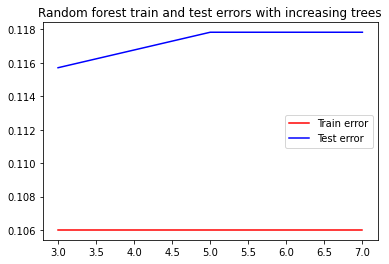

In [9]:
import matplotlib.pyplot as plt

plt.plot(depths, train_errors, c="r", label="Train error")
plt.plot(depths, test_errors, c="b", label="Test error")
plt.title("Random forest train and test errors with increasing trees")
plt.legend()
plt.show()